In [1]:
import pandas as pd

import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
nltk.download('all')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords_eng = stopwords.words("english")

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/Binaya/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/Binaya/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/Binaya/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/Binaya/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/Binaya/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

In [2]:
df = pd.read_csv('../DATASET/new_data.csv')

In [3]:
df.head()

,title,Published_on,News_agency,URL,summary,Country,language,tag
0,UN agency pauses Gaza food aid deliveries afte...,"Wed, 21 Feb 2024 15:57:00 GMT",The Guardian,https://news.google.com/rss/articles/CBMicWh0d...,UN agency pauses Gaza food aid deliveries afte...,US,en,WORLD
1,Latest Israel-Hamas war news and Gaza conflict...,"Wed, 21 Feb 2024 14:42:17 GMT",The Washington Post,https://news.google.com/rss/articles/CBMiVWh0d...,Latest Israel-Hamas war news and Gaza conflict...,US,en,WORLD
2,Israel Gaza: China condemns US veto of call fo...,"Wed, 21 Feb 2024 12:51:40 GMT",BBC.com,https://news.google.com/rss/articles/CBMiM2h0d...,Israel Gaza: China condemns US veto of call fo...,US,en,WORLD
3,Navalny’s mother goes to court over officials’...,"Wed, 21 Feb 2024 12:48:00 GMT",The Hill,https://news.google.com/rss/articles/CBMiXGh0d...,Navalny’s mother goes to court over officials’...,US,en,WORLD
4,Police fire tear gas on Indian farmers marchin...,"Wed, 21 Feb 2024 11:43:00 GMT",Reuters India,https://news.google.com/rss/articles/CBMia2h0d...,Police fire tear gas on Indian farmers marchin...,US,en,WORLD


In [4]:
df.shape

(6393, 8)

In [5]:
df.columns

Index(['title', 'Published_on', 'News_agency', 'URL', 'summary', 'Country',
       'language', 'tag'],
      dtype='object')

In [6]:
df.describe()

,title,Published_on,News_agency,URL,summary,Country,language,tag
count,6393,6393,6393,6393,6393,6393,6393,6393
unique,2866,2557,951,2864,3041,13,1,8
top,Firefly Aerospace's Alpha rocket put a satelli...,"Wed, 21 Feb 2024 09:00:00 GMT",BBC.com,https://news.google.com/rss/articles/CBMiU2h0d...,Ukraine war: Dozens of Russian troops 'die in ...,AU,en,HEALTH
freq,12,39,231,12,10,518,6393,900


In [7]:
df.isnull().sum()

title           0
Published_on    0
News_agency     0
URL             0
summary         0
Country         0
language        0
tag             0
dtype: int64

In [8]:
df.dtypes

title           object
Published_on    object
News_agency     object
URL             object
summary         object
Country         object
language        object
tag             object
dtype: object

In [9]:
df['published_date'] = pd.to_datetime(df['Published_on'])

In [10]:
df['published_year'] = df['published_date'].dt.year

In [11]:
df['published_year'].unique()

array([2024, 2023, 2022], dtype=int32)

In [12]:
df['published_year'].value_counts()

published_year
2024    6300
2023      92
2022       1
Name: count, dtype: int64

In [13]:
df['published_year'].value_counts(normalize=True)*100

published_year
2024    98.545284
2023     1.439074
2022     0.015642
Name: proportion, dtype: float64

In [14]:
df['published_month'] = df['published_date'].dt.month

In [15]:
df['published_month'].value_counts(normalize=True)*100

published_month
2     97.997810
1      0.547474
12     0.437979
11     0.234632
9      0.218990
10     0.203347
6      0.109495
8      0.109495
7      0.062568
5      0.031284
3      0.031284
4      0.015642
Name: proportion, dtype: float64

In [16]:
df['published_month'].nunique()

12

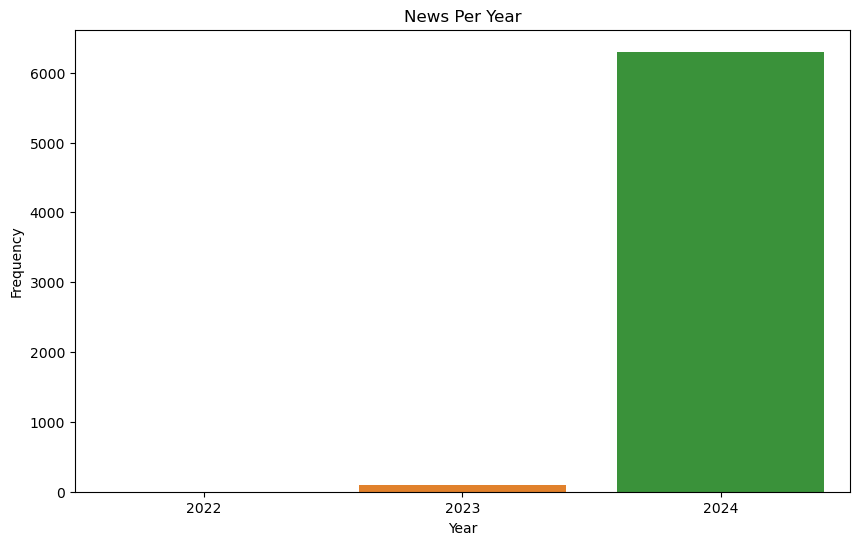

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='published_year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('News Per Year')
plt.show()

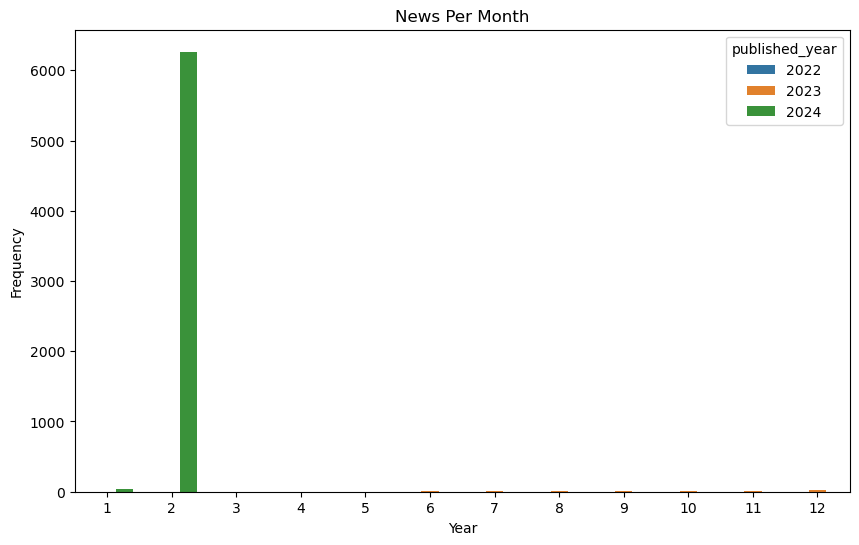

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='published_month', hue='published_year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('News Per Month')
plt.show()

In [19]:
df.Country.nunique()

13

In [20]:
df.Country.value_counts(normalize=True)*100

Country
AU    8.102612
IN    7.930549
DE    7.789770
FR    7.789770
RU    7.789770
CN    7.774128
BR    7.774128
ES    7.758486
IT    7.742844
JP    7.742844
US    7.602065
CA    7.539496
GB    6.663538
Name: proportion, dtype: float64

In [21]:
df.language.value_counts(normalize=True)*100

language
en    100.0
Name: proportion, dtype: float64

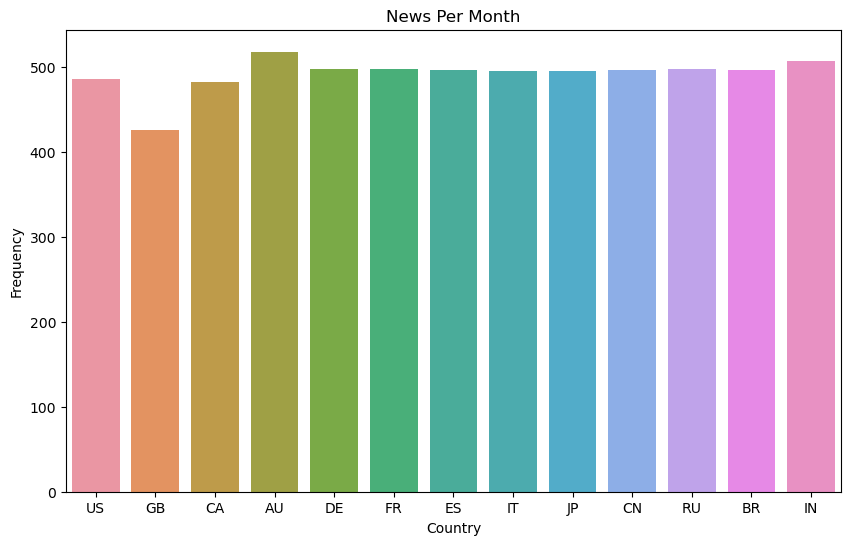

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Country')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('News Per Month')
plt.show()

In [23]:
df.tag.nunique()

8

In [24]:
df.tag.value_counts(normalize=True)*100

tag
HEALTH           14.077898
NATION           13.436571
SPORTS           13.405287
BUSINESS         13.139371
TECHNOLOGY       11.888003
SCIENCE          11.684655
WORLD            11.356171
ENTERTAINMENT    11.012044
Name: proportion, dtype: float64

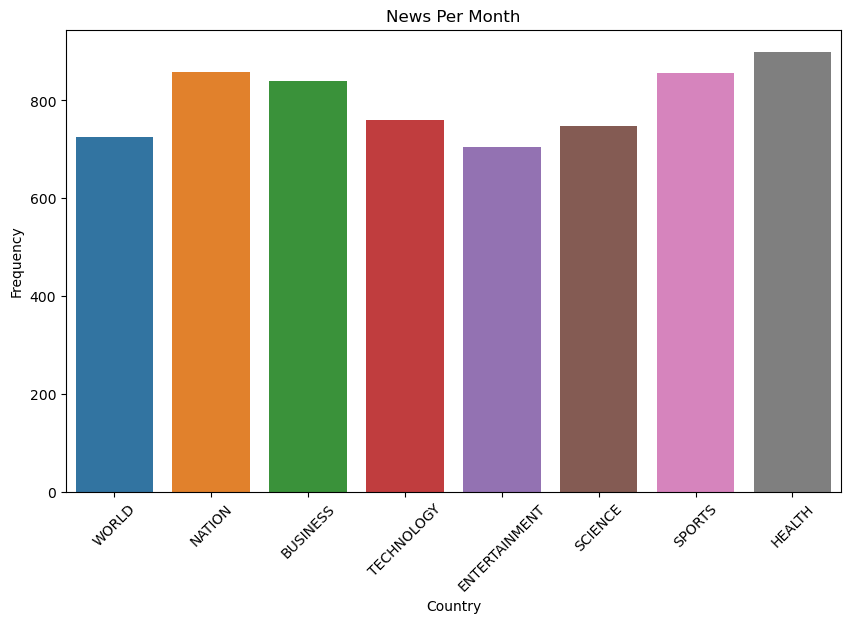

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tag')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('News Per Month')
plt.show()

In [26]:
def clean_text(text): 
    for agency in df['News_agency'].unique():
        agency = re.sub(r'\(|\)|\|', '', agency)
        text = re.sub(r'\(|\)|\|', '', text)
        text = re.sub(rf'{agency}', ' ', text)
    return re.sub(r'[^\w\s]', '', text)

In [27]:
def remove_whitespace(text): 
    return text.strip()

In [28]:
def convert_to_lowercase(text): 
    return text.lower()

In [29]:
def remove_punctuation(text): 
    return text.translate(str.maketrans('', '', string.punctuation))

In [30]:
def tokenize(text): 
    return word_tokenize(text)

In [31]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stopwords_eng]

In [32]:
lem = WordNetLemmatizer()
def lemmatization(tokens):
    return [lem.lemmatize(word) for word in tokens]

In [33]:
def preprocess_pipeline(text): 
    text = clean_text(text)
    text = remove_whitespace(text)
    text = convert_to_lowercase(text)
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    return lemmatization(tokens)

In [34]:
df['preprocessed_tokens'] = df['summary'].apply(preprocess_pipeline)

In [35]:
df.head()

,title,Published_on,News_agency,URL,summary,Country,language,tag,published_date,published_year,published_month,preprocessed_tokens
0,UN agency pauses Gaza food aid deliveries afte...,"Wed, 21 Feb 2024 15:57:00 GMT",The Guardian,https://news.google.com/rss/articles/CBMicWh0d...,UN agency pauses Gaza food aid deliveries afte...,US,en,WORLD,2024-02-21 15:57:00,2024,2,"[un, agency, pause, gaza, food, aid, delivery,..."
1,Latest Israel-Hamas war news and Gaza conflict...,"Wed, 21 Feb 2024 14:42:17 GMT",The Washington Post,https://news.google.com/rss/articles/CBMiVWh0d...,Latest Israel-Hamas war news and Gaza conflict...,US,en,WORLD,2024-02-21 14:42:17,2024,2,"[latest, israelhamas, war, news, gaza, conflic..."
2,Israel Gaza: China condemns US veto of call fo...,"Wed, 21 Feb 2024 12:51:40 GMT",BBC.com,https://news.google.com/rss/articles/CBMiM2h0d...,Israel Gaza: China condemns US veto of call fo...,US,en,WORLD,2024-02-21 12:51:40,2024,2,"[israel, gaza, china, condemns, u, veto, call,..."
3,Navalny’s mother goes to court over officials’...,"Wed, 21 Feb 2024 12:48:00 GMT",The Hill,https://news.google.com/rss/articles/CBMiXGh0d...,Navalny’s mother goes to court over officials’...,US,en,WORLD,2024-02-21 12:48:00,2024,2,"[navalnys, mother, go, court, official, refusa..."
4,Police fire tear gas on Indian farmers marchin...,"Wed, 21 Feb 2024 11:43:00 GMT",Reuters India,https://news.google.com/rss/articles/CBMia2h0d...,Police fire tear gas on Indian farmers marchin...,US,en,WORLD,2024-02-21 11:43:00,2024,2,"[police, fire, tear, gas, indian, farmer, marc..."


In [36]:
def join_tokens(tokens): 
    return ' '.join(tokens)

In [37]:
df['clean_text'] = df['preprocessed_tokens'].apply(join_tokens)

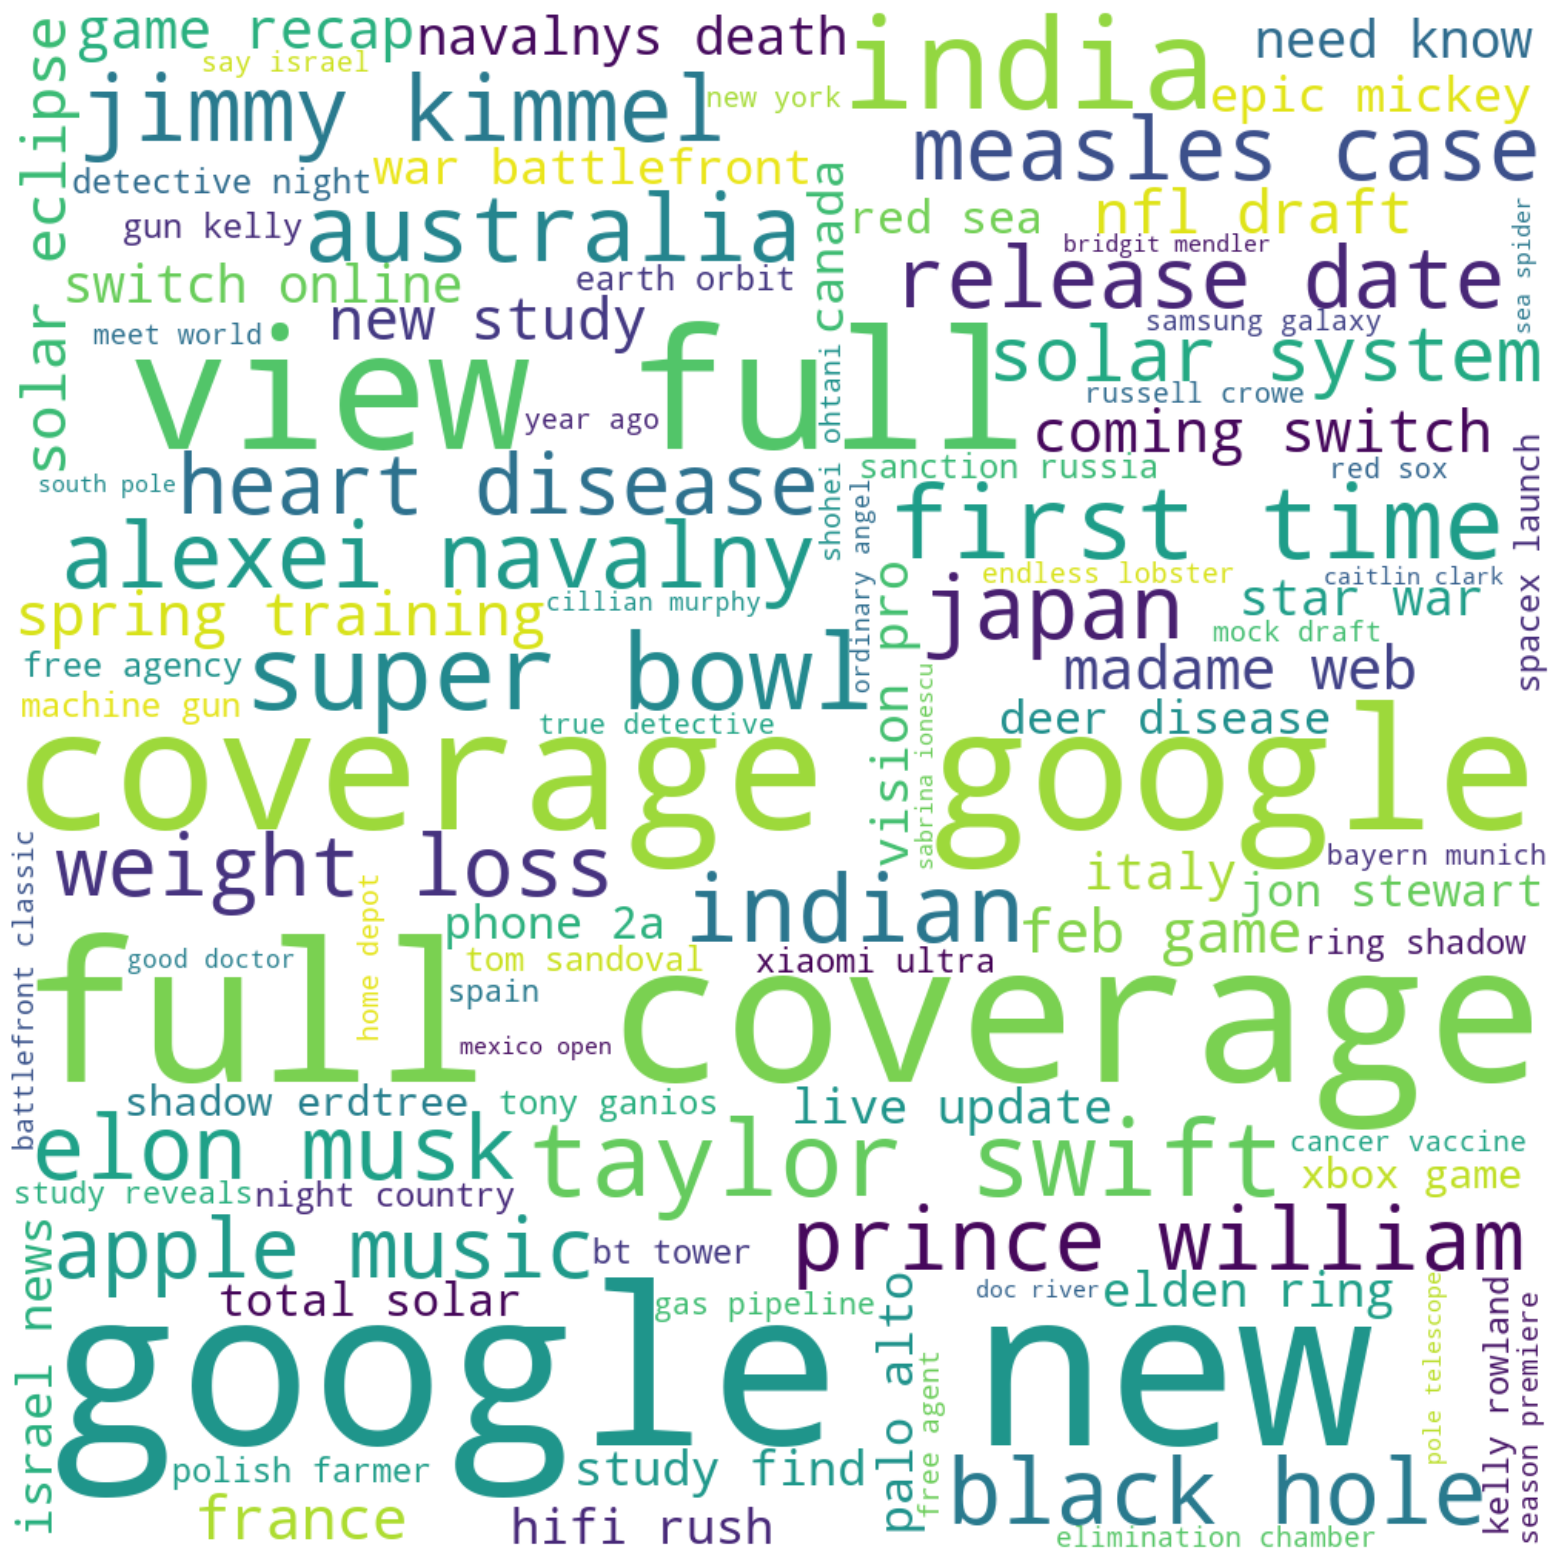

In [38]:
text = ' '.join(df['clean_text'])

plt.figure(figsize = (20,20))

wordcloud = WordCloud(max_words = 100 , width = 1000 , height = 1000 , background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

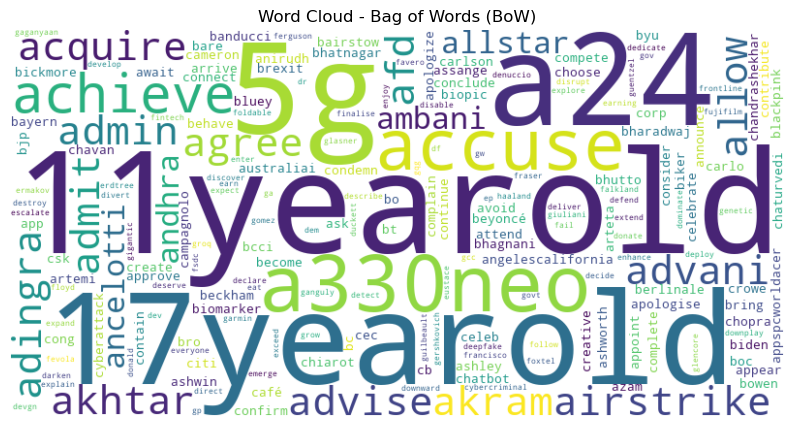

In [39]:
vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(df['clean_text'])

feature_names_bow = vectorizer_bow.get_feature_names_out()

bow_text = ' '.join(feature_names_bow)

wordcloud_bow = WordCloud(width=800, height=400, background_color='white').generate(bow_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bag of Words (BoW)')
plt.show()

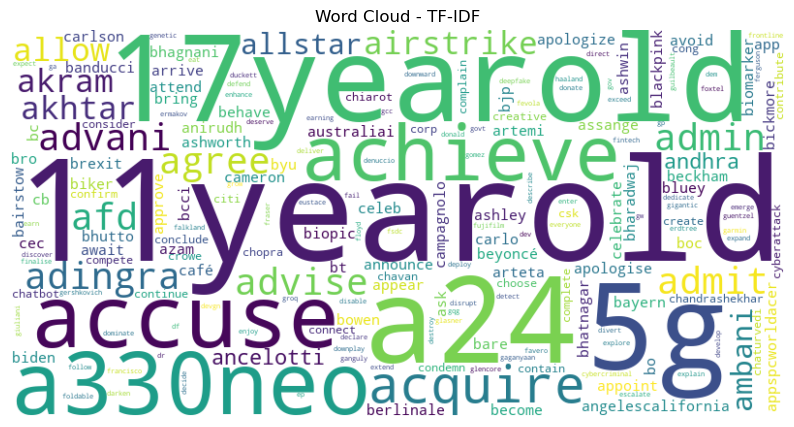

In [40]:
vectorizer_tfidf = TfidfVectorizer()

X_tfidf = vectorizer_tfidf.fit_transform(df['clean_text'])

feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

tfidf_text = ' '.join(feature_names_tfidf)

wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate(tfidf_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - TF-IDF')
plt.show()


In [41]:
df.to_csv('../DATASET/preprocessed/preprocessed_news.csv')

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


In [43]:
X_train,X_test,y_train,y_test = train_test_split(df['clean_text'], df.tag, test_size=0.3, random_state=42,stratify=df['tag'])

In [44]:
def display_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(xticks_rotation='vertical')
    plt.show()

In [45]:
# combining two different vectorization method 
rfc = Pipeline([('vect', CountVectorizer()),
                 ('model', RandomForestClassifier(n_estimators=1000,
                                                  criterion="gini"))])

rfc_model = rfc.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
print("accuracy:", round(accuracy_score(y_test, rfc_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, rfc_pred))

accuracy: 88.06%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.95      0.84      0.89       252
ENTERTAINMENT       0.95      0.86      0.90       211
       HEALTH       0.94      0.91      0.93       270
       NATION       0.61      0.88      0.72       258
      SCIENCE       0.97      0.98      0.97       224
       SPORTS       0.95      0.87      0.91       257
   TECHNOLOGY       0.93      0.89      0.91       228
        WORLD       0.95      0.81      0.87       218

     accuracy                           0.88      1918
    macro avg       0.90      0.88      0.89      1918
 weighted avg       0.90      0.88      0.89      1918



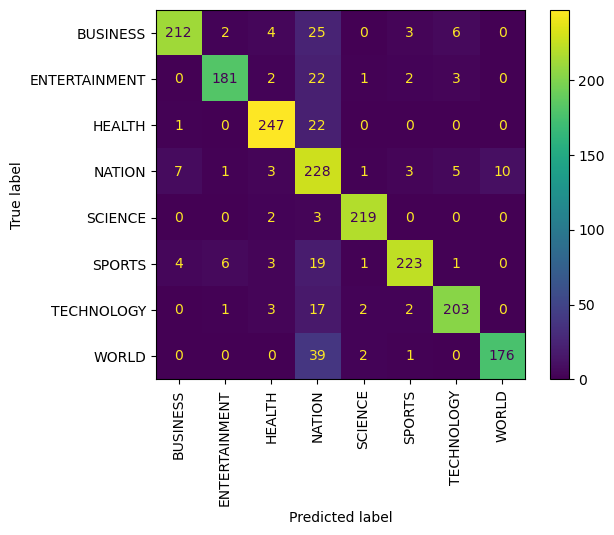

In [46]:
display_confusion_matrix(y_test, rfc_pred, rfc_model.classes_)

In [47]:
# using TFidf vectorization method 
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF vectorizer
    ('classifier', RandomForestClassifier(random_state=42))  # Example classifier
])

rfc_tfidf_model = tfidf_pipeline.fit(X_train, y_train)
rfc_tfidf_pred = tfidf_pipeline.predict(X_test)

print("accuracy:", round(accuracy_score(y_test, rfc_tfidf_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, rfc_tfidf_pred))

accuracy: 88.01%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.94      0.85      0.89       252
ENTERTAINMENT       0.94      0.86      0.90       211
       HEALTH       0.94      0.92      0.93       270
       NATION       0.63      0.88      0.73       258
      SCIENCE       0.97      0.98      0.97       224
       SPORTS       0.93      0.85      0.89       257
   TECHNOLOGY       0.93      0.89      0.91       228
        WORLD       0.93      0.82      0.87       218

     accuracy                           0.88      1918
    macro avg       0.90      0.88      0.89      1918
 weighted avg       0.90      0.88      0.88      1918



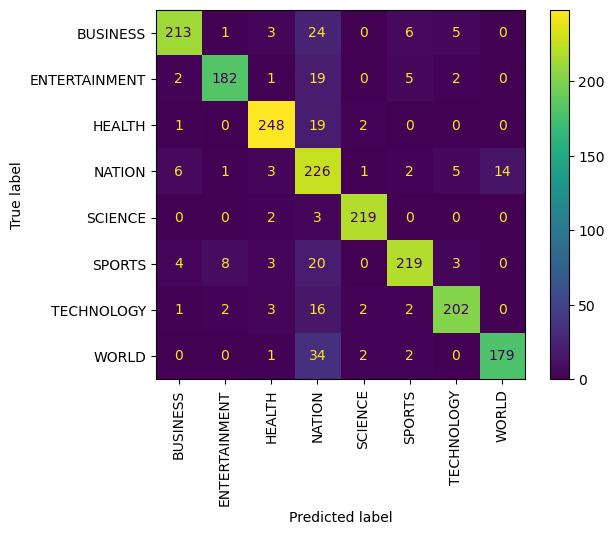

In [48]:
display_confusion_matrix(y_test, rfc_tfidf_pred, rfc_tfidf_model.classes_)

In [49]:
lr = Pipeline([('vect', CountVectorizer()),
               ('model', LogisticRegression(penalty='l2',
                                            C=1,
                                            solver='saga',
                                            multi_class='multinomial',
                                            max_iter=1000,
                                            class_weight='balanced'))])

lr_model = lr.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print("Accuracy: ", round(accuracy_score(y_test, lr_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, lr_pred))

Accuracy:  89.73%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.93      0.89      0.91       252
ENTERTAINMENT       0.92      0.90      0.91       211
       HEALTH       0.93      0.94      0.94       270
       NATION       0.69      0.82      0.75       258
      SCIENCE       0.97      0.98      0.98       224
       SPORTS       0.96      0.91      0.94       257
   TECHNOLOGY       0.98      0.89      0.93       228
        WORLD       0.86      0.84      0.85       218

     accuracy                           0.90      1918
    macro avg       0.91      0.90      0.90      1918
 weighted avg       0.90      0.90      0.90      1918



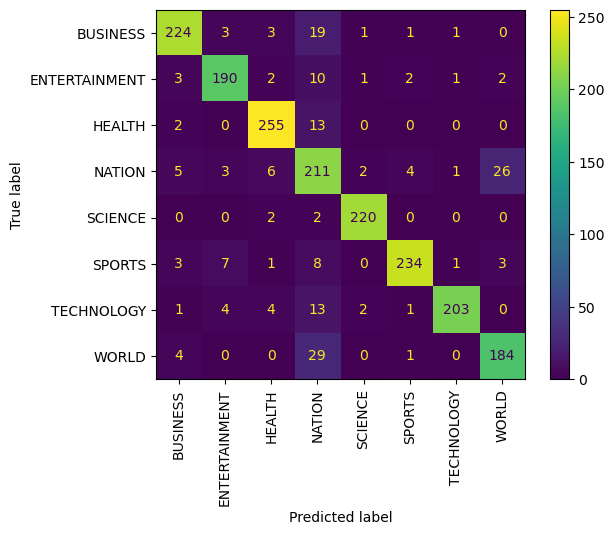

In [50]:
display_confusion_matrix(y_test, lr_pred, lr_model.classes_)

In [51]:
lr = Pipeline([('tfidf', TfidfVectorizer()),
               ('model', LogisticRegression(penalty='l2',
                                            C=1,
                                            solver='saga',
                                            multi_class='multinomial',
                                            max_iter=1000,
                                            class_weight='balanced'))])

lr_model = lr.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print("Accuracy: ", round(accuracy_score(y_test, lr_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, lr_pred))

Accuracy:  91.24%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.90      0.90      0.90       252
ENTERTAINMENT       0.90      0.92      0.91       211
       HEALTH       0.96      0.96      0.96       270
       NATION       0.77      0.79      0.78       258
      SCIENCE       0.97      0.99      0.98       224
       SPORTS       0.97      0.95      0.96       257
   TECHNOLOGY       0.97      0.91      0.94       228
        WORLD       0.85      0.88      0.86       218

     accuracy                           0.91      1918
    macro avg       0.91      0.91      0.91      1918
 weighted avg       0.91      0.91      0.91      1918



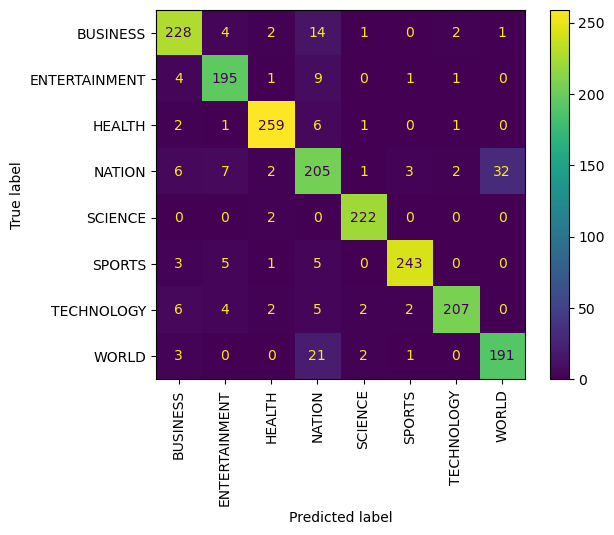

In [52]:
display_confusion_matrix(y_test, lr_pred, lr_model.classes_)

In [53]:
sv = Pipeline([('vect', CountVectorizer()),
               ('model', svm.SVC(kernel='linear',
                                 C=1.0,
                                 max_iter=5000))])

sv_model = sv.fit(X_train, y_train)

sv_pred = sv_model.predict(X_test)

print("Accuracy: ", round(accuracy_score(y_test, sv_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, sv_pred))

Accuracy:  88.01%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.90      0.87      0.88       252
ENTERTAINMENT       0.91      0.87      0.89       211
       HEALTH       0.92      0.93      0.93       270
       NATION       0.65      0.80      0.72       258
      SCIENCE       0.98      0.98      0.98       224
       SPORTS       0.95      0.88      0.91       257
   TECHNOLOGY       0.94      0.87      0.90       228
        WORLD       0.87      0.84      0.86       218

     accuracy                           0.88      1918
    macro avg       0.89      0.88      0.88      1918
 weighted avg       0.89      0.88      0.88      1918



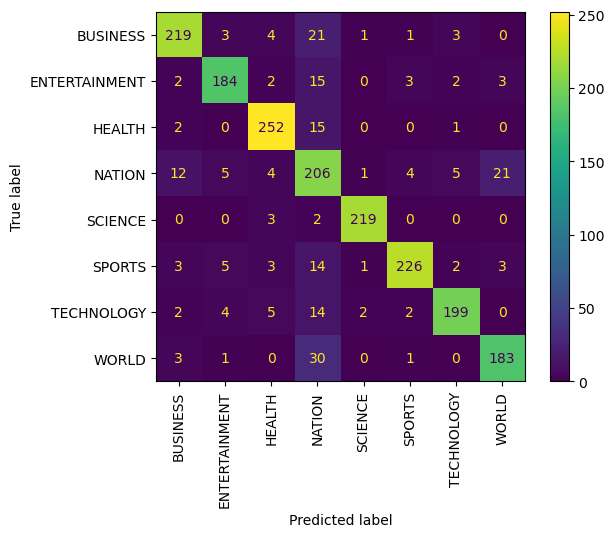

In [54]:
display_confusion_matrix(y_test, sv_pred, sv_model.classes_)

In [55]:
sv = Pipeline([('tfidf', TfidfVectorizer()),
               ('model', svm.SVC(kernel='linear',
                                 C=1.0,
                                 max_iter=5000))])

sv_model = sv.fit(X_train, y_train)

sv_pred = sv_model.predict(X_test)

print("Accuracy: ", round(accuracy_score(y_test, sv_pred)*100,2), "\b%")
print("Classification Report:\n\n", classification_report(y_test, sv_pred))

Accuracy:  90.93%
Classification Report:

                precision    recall  f1-score   support

     BUSINESS       0.89      0.90      0.89       252
ENTERTAINMENT       0.96      0.93      0.94       211
       HEALTH       0.96      0.94      0.95       270
       NATION       0.71      0.84      0.77       258
      SCIENCE       0.98      0.98      0.98       224
       SPORTS       0.99      0.93      0.96       257
   TECHNOLOGY       0.99      0.90      0.94       228
        WORLD       0.87      0.86      0.87       218

     accuracy                           0.91      1918
    macro avg       0.92      0.91      0.91      1918
 weighted avg       0.92      0.91      0.91      1918



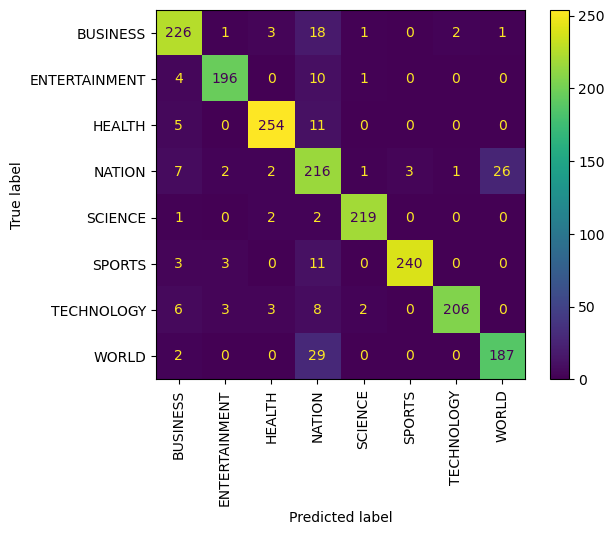

In [56]:
display_confusion_matrix(y_test, sv_pred, sv_model.classes_)